This notebook reproduces evaluation dataset analyses as as reported in the [Qemistree manuscript](https://www.biorxiv.org/content/10.1101/2020.05.04.077636v1)

- The mass spectrometry data, metadata, and methods for the evaluation dataset have been
deposited on the GNPS/MassIVE public repository under the accession number [MSV000083306](ftp://massive.ucsd.edu/MSV000083306)

- The mass-spectromtery files were processed using Mzmine2 (version 2.38) with [these parameters](ftp://massive.ucsd.edu/MSV000083306/updates/2019-07-09_lfnothias_e6d54613/other/) followed by feature-based molecular networking (FBMN) in GNPS: [GNPS task](https://gnps.ucsd.edu/ProteoSAFe/status.jsp?task=044e981ff0d84246ae5c91ef3db643a8)

- The resulting files were analysed using q2-qemistree in GNPS: [GNPS Task](https://proteomics2.ucsd.edu/ProteoSAFe/status.jsp?task=8ca56d6e33bc4106b46ba5e3510c91cb). This generated the feature table, molecular fingerprints, feature data and chemical tree used for the analyses below.

In [46]:
import qiime2.plugins.diversity.actions as q2_diversity
import qiime2.plugins.feature_table.actions as q2_feature_table
from qiime2 import Artifact
from qiime2 import Metadata
import qiime2 as q2
import unifrac
from biom import load_table

from skbio import DistanceMatrix, OrdinationResults
import pandas as pd
import numpy as np
import seaborn as sns
import itertools
from skbio import OrdinationResults
from skbio.stats.distance import permanova
from skbio.tree import TreeNode
from skbio.stats.ordination import pcoa
from skbio.diversity import beta_diversity
from scipy.cluster.hierarchy import linkage
from scipy.stats import kruskal

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['pdf.fonttype'] = 42
%matplotlib inline

In [47]:
def load_mf(fn, index='#SampleID', sep='\t'):
    _df = pd.read_csv(fn, sep=sep, dtype='str', na_values=[], keep_default_na=False)
    _df.set_index(index, inplace=True)
    return _df

In [48]:
def summarize_distances(dm, metric, metadata, grouping='ATTRIBUTE_Proportions', 
                        catdiff='ATTRIBUTE_Experiment', comparison='across'):
    
    if comparison not in {'across', 'within'}:
        raise ValueError('Unsupported comparison style: %s' % comparison)
    
    groups = metadata[grouping].unique()
    pair_dist = {}
    
    for val in groups:
        # exclude blanks
        if val == '0_0_0_0':
            continue
            
        # subset to only the samples in this grouping category
        sampls = set(dm.ids).intersection(metadata[metadata[grouping] == val].index)

        if comparison == 'across':
            subset_md = metadata.loc[sampls] # only samples with grouping = val
            categories = subset_md[catdiff].unique() # catdiffs per grouping = val
            cat_samp_list = [] # list of samples per catdiff, len of this list = num_categories

            for cat in categories:
                cat_samp_list.append(list(subset_md[subset_md[catdiff] ==  cat].index))
            pair_cats = list(itertools.combinations(range(len(categories)), 2)) # pairs of categories

            for pairs in pair_cats:
                res = list(itertools.product(*[cat_samp_list[pairs[0]],cat_samp_list[pairs[1]]])) # all pairs across categories
                for samp_pair in res:
                    pair_dist[samp_pair] = [dm[samp_pair], val, metric, 'across']
        elif comparison == 'within':
            
            for _, _df in metadata.loc[sampls].groupby(catdiff):
            
                res = list(itertools.combinations(_df.index, 2)) # all pairs for a given proportion
                
                for samp_pair in res:
                    pair_dist[samp_pair] = [dm[samp_pair], val, metric, 'within']
            

    return pd.DataFrame.from_dict(data=pair_dist, orient='index',
                                  columns=['distance', 'grouping', 'metric', 'comparison'])

In [49]:
mapping = load_mf('data/qe_qert_qiime2_metadata.tsv', 'sample_name')

In [50]:
[i for i in mapping.index if 'SPE-blanc' in i]

[]

### Ordinations & Distances

In [51]:
_mapping = mapping.copy()
results = {}

data_locations = [
    ('ATTRIBUTE_Experiment',
     'data/qe_qert_qiime2_metadata.tsv',
     'data/ftable_qe_qert.qza',
     'data/tree_qe_qert.qza'),
]

for benchmark, mapping_path, table_path, tree_path in  data_locations: 
    
    table = q2.Artifact.load(table_path)
    tree = q2.Artifact.load(tree_path)
    _mapping = load_mf(mapping_path, 'sample_name')
    
    df = table.view(pd.DataFrame)
    
    results[benchmark] = {}

    # List the number of blanks in this dataset:
    # there's some samples that aren't identified as blanks but that have to be removed
    blanks = set(_mapping.query('ATTRIBUTE_Sample_type != "Sample"').index)
    blanks = set(df.index.intersection(blanks))
    
    samples = set(df.index) - set(blanks)

    print('[%s] blanks: %d, samples: %d' % (benchmark, len(blanks), len(samples)))

    # Add a new column that describes if the sample in this dataset is a blank.

    _mapping['is_blank'] = "False"
    _mapping.loc[blanks, 'is_blank'] = "True"

    _mapping.replace(to_replace='', value='NA', inplace=True)

    # first remove the blank samples, note this depends in a column that was created a few cells above
    _table, = q2_feature_table.filter_samples(table=table, metadata=q2.Metadata(_mapping), where='is_blank = "False"')
    
    results[benchmark]['mapping'] = _mapping.loc[samples].copy()
    results[benchmark]['table'] = _table.view(pd.DataFrame)
    results[benchmark]['tree'] = tree.view(TreeNode)

    for metric in ['Bray-Curtis', 'Weighted UniFrac']:

        if metric == 'Bray-Curtis':
            dm, = q2_diversity.beta(table=_table, metric='braycurtis')
        elif metric == 'Weighted UniFrac':
            dm, = q2_diversity.beta_phylogenetic(table=_table, phylogeny=tree,
                                                 metric='weighted_normalized_unifrac', n_jobs=2)
        else:
            raise ValueError("Not expecting this metric %s" % metric)

        results[benchmark][metric] = {}
        results[benchmark][metric]['dm'] = dm.view(DistanceMatrix)
        results[benchmark][metric]['pcoa'] = q2_diversity.pcoa(dm)[0].view(OrdinationResults)

[ATTRIBUTE_Experiment] blanks: 36, samples: 162


/Users/priya/miniconda3/envs/qiime2-2019.7/lib/python3.6/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.45901009180774877 and the largest is 22.94938356795757.
  RuntimeWarning
/Users/priya/miniconda3/envs/qiime2-2019.7/lib/python3.6/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes sec

There are three categories in the metadata `Proportions`, `Batch`, and `Triplicate_number`. The first works as a mixture identifier, the second one represents the run (i.e. chromatography conditions) where the samples were processed and the third is the sample identifier that is matched across sammples.

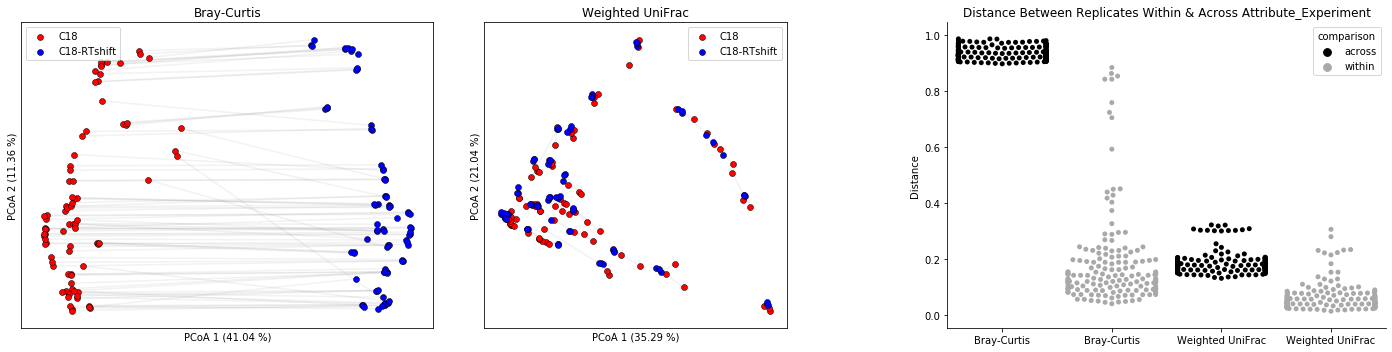

In [52]:
colors = {'C18': 'red',
          'C18-RTshift': 'blue'}

for benchmark, benchmark_data in results.items():
    fig, axes = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=False, figsize=(20, 5))
    
    _mapping = benchmark_data['mapping']

    # save the distance comparisons for each metric
    distances = []

    for metric, ax in zip(['Bray-Curtis', 'Weighted UniFrac'], axes):
        distances.append(summarize_distances(benchmark_data[metric]['dm'], metric + ' across',
                                             _mapping, comparison='across', catdiff=benchmark))
        distances.append(summarize_distances(benchmark_data[metric]['dm'], metric + ' within',
                                             _mapping, comparison='within', catdiff=benchmark))

        ax.set_aspect(1, adjustable='box', anchor='SW')
        ax.set_title(metric)

        pc = benchmark_data[metric]['pcoa']

        # draw the lines first
        for proportion, _df in _mapping.groupby('ATTRIBUTE_Proportions'):
            for triplicate, __df in _df.groupby('Triplicate_number'):
                
                for u, v in itertools.combinations(__df.index, 2):
                    # use the underlying numpy array so that matplotlib won't take labels
                    # from the columns/index
                    _pc = pc.samples.loc[[u, v]].values
                    ax.plot(_pc[:, 0], _pc[:, 1], c='gray', alpha=0.1, zorder=-999, label=None)

        # draw the points on top of the lines so that lines look less messy
        for bench_set, _df in _mapping.groupby(benchmark):
            _pc = pc.samples.loc[_df.index]

            ax.scatter(_pc.iloc[:, 0], _pc.iloc[:, 1],
                       c=colors.get(bench_set, None),
                       edgecolors='black', linewidth=0.5,
                       label='%s' % (bench_set.replace('_', ' ')))

        ax.set_xlabel('PCoA 1 (%.2f %%)' % (pc.proportion_explained[0] * 100))
        ax.set_ylabel('PCoA 2 (%.2f %%)' % (pc.proportion_explained[1] * 100))

        # remove the ticks and coordinate values
        ax.set_xticks([])
        ax.set_yticks([])

        ax.legend()

    # last axes space holds the summary
    ax = axes[-1]
    ax.set_aspect('auto')

    distances = pd.concat(distances)
    sns.swarmplot(data=distances, x='metric', y='distance', ax=ax, hue='comparison',
                  order=['Bray-Curtis across','Bray-Curtis within', 
                         'Weighted UniFrac across','Weighted UniFrac within'],
                  hue_order = ['across', 'within'],
                  palette = {'across':'k', 'within':'#A9A9A9'})

    ax.set(xlabel='', ylabel="Distance")
    ax.set_xticklabels(['Bray-Curtis', 'Bray-Curtis', 'Weighted UniFrac', 'Weighted UniFrac'])

    ax.set_title(('Distance between replicates within & across %s' % (benchmark)).title())

    sns.despine(ax=ax)

    plt.tight_layout()

    plt.savefig('figures/benchmark_PCoA.pdf')

In [53]:
# permanova Bray-Curtis
dm = benchmark_data['Bray-Curtis']['dm']
labels = [mapping.loc[sname, 'ATTRIBUTE_Experiment'] for sname in dm.ids]
permanova(dm, labels)

method name               PERMANOVA
test statistic name        pseudo-F
sample size                     162
number of groups                  2
test statistic              120.758
p-value                       0.001
number of permutations          999
Name: PERMANOVA results, dtype: object

In [54]:
# permanova UniFrac
dm = benchmark_data['Weighted UniFrac']['dm']
labels = [mapping.loc[sname, 'ATTRIBUTE_Experiment'] for sname in dm.ids]
permanova(dm, labels)

method name               PERMANOVA
test statistic name        pseudo-F
sample size                     162
number of groups                  2
test statistic              18.2239
p-value                       0.001
number of permutations          999
Name: PERMANOVA results, dtype: object

### Heatmap

- Load the metadata, and feature table
- Subset to keep pure fecal, tomato and serum samples
- Order samples by sample type and batch

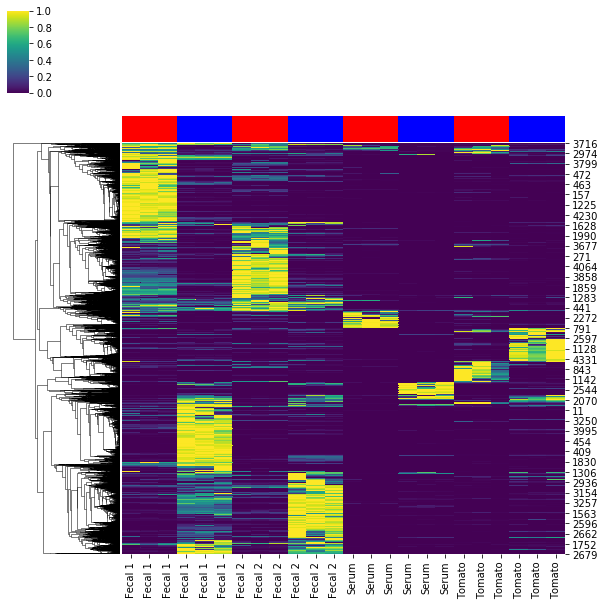

In [55]:
matrix = results['ATTRIBUTE_Experiment']['table']
mapping_file = results['ATTRIBUTE_Experiment']['mapping']

# filter everything that's not a pure sample
mapping_file = mapping_file[mapping_file.ATTRIBUTE_Proportions.str.find('100') != -1].copy()

def name_sample_types(row):
    
    if 'F1' in row.name:
        return 'Fecal 1'
    elif 'F2' in row.name:
        return 'Fecal 2'
    elif 'NIST' in row.name:
        return 'Serum'
    elif 'To' in row.name:
        return 'Tomato'
    else:
        raise ValueError('Something went wrong')

mapping_file['sample_type'] = mapping_file.apply(name_sample_types, axis=1)

# sort the data for readability
mapping_file.sort_values(['sample_type', 'ATTRIBUTE_Experiment', 'Triplicate_number'], inplace=True)

matrix = matrix.loc[mapping_file.index].T
colors = mapping_file.ATTRIBUTE_Experiment.replace({
    'C18': 'red',
    'C18-RTshift': 'blue',  
}).values

sns.clustermap(data=matrix.values, row_cluster=True, col_cluster=False,
               col_colors=colors, standard_scale=0, 
               xticklabels=mapping_file.sample_type.values, cmap='viridis')

plt.savefig('figures/benchmark_heatmap.pdf')

### Tree visualization

Below, we generate a tree with the top `n` most abundant features in the tree sample types for the purpose of illustration.

In [56]:
sum_sample_types = pd.concat([matrix.T, mapping_file], axis=1).groupby('sample_type').sum().T
sum_sample_types.head()

sample_type,Fecal 1,Fecal 2,Serum,Tomato
000d61d2d8eaf541620f807b3c08177f,4.692508e+07,9.113247e+08,2.762200e+05,6.439097e+04
0014215d4f619efae9c80706d23a2317,1.749325e+06,5.781492e+06,7.165389e+02,2.057233e+07
00217b2e49650beafbdc659fec5501b2,1.150306e+08,2.262295e+08,0.000000e+00,0.000000e+00
002344d8e36df7d1cc3cf97bd72bb83e,9.558439e+09,1.108801e+07,4.831899e+06,7.703463e+06
002abfebe07fc0a4797c14bfa2dee4be,2.284211e+08,1.433694e+09,5.886861e+05,2.448296e+09


In [57]:
# get top n most abundant feature in each sample type
n=150
top_fecal1 = sum_sample_types.sort_values(by='Fecal 1', ascending=False).index[:n].to_list()
top_serum = sum_sample_types.sort_values(by='Serum', ascending=False).index[:n].to_list()
top_tomato = sum_sample_types.sort_values(by='Tomato', ascending=False).index[:n].to_list()
top = list((set(top_fecal1).union(set(top_serum)).union(set(top_tomato))))
len(top)

409

In [58]:
# feature data
fdata = Artifact.load('data/classified_fdata_qe_qert.qza').view(pd.DataFrame)
fdata_top = fdata.loc[top]
fdata_top.reset_index().to_csv('data/fdata_top450_qe_qert.txt', 
                                sep='\t', 
                                index=False)
! qiime tools import --input-path data/fdata_top450_qe_qert.txt \
  --output-path data/fdata_top450_qe_qert.qza \
  --type FeatureData['Molecules']

Imported data/fdata_top450_qe_qert.txt as TSVMoleculesFormat to data/fdata_top450_qe_qert.qza


In [59]:
# prune tree to include top features
! qiime qemistree prune-hierarchy \
  --i-tree data/tree_qe_qert.qza \
  --i-feature-data data/fdata_top450_qe_qert.qza \
  --p-column '#featureID' \
  --o-pruned-tree data/tree_qe_qert_top450.qza

Saved Phylogeny[Rooted] to: data/tree_qe_qert_top450.qza


In [60]:
# filter feature table to keep pure samples
! qiime feature-table filter-samples \
--i-table data/ftable_qe_qert.qza \
--m-metadata-file data/mapping_file_pure_samples.txt \
--o-filtered-table data/ftable_qe_qert_pure.qza

Saved FeatureTable[Frequency] to: data/ftable_qe_qert_pure.qza


In [61]:
# group samples by sample type
! qiime feature-table group \
--i-table data/ftable_qe_qert_pure.qza \
--p-axis sample \
--m-metadata-file data/mapping_file_pure_samples.txt \
--m-metadata-column sample_type \
--p-mode mean-ceiling \
--o-grouped-table data/ftable_qe_qert_grouped_sample.qza

Saved FeatureTable[Frequency] to: data/ftable_qe_qert_grouped_sample.qza


In [62]:
# group samples by batch
! qiime feature-table group \
--i-table data/ftable_qe_qert_pure.qza \
--p-axis sample \
--m-metadata-file data/mapping_file_pure_samples.txt \
--m-metadata-column ATTRIBUTE_Experiment \
--p-mode mean-ceiling \
--o-grouped-table data/ftable_qe_qert_grouped_batch.qza

Saved FeatureTable[Frequency] to: data/ftable_qe_qert_grouped_batch.qza


Below, we generate the QZV files with qemistree visualization. These files can be dragged and dropped in [QIIME2 View](https://view.qiime2.org/) to interactively visualize chemical trees in [iTOL](https://itol.embl.de/upload.cgi). 

In [64]:
# grouped by sample type, labeled by direct parent & parentmz (when there is no annotation)
! qiime qemistree plot \
--i-tree data/tree_qe_qert_top450.qza \
--i-feature-metadata data/fdata_top450_qe_qert.qza \
--i-grouped-table data/ftable_qe_qert_grouped_sample.qza \
--p-category direct_parent \
--o-visualization data/qemistree_top450_dp.qzv 

In [65]:
# grouped by batch, labeled by direct parent & parentmz (when there is no annotation)
! qiime qemistree plot \
--i-tree data/tree_qe_qert_top450.qza \
--i-feature-metadata data/fdata_top450_qe_qert.qza \
--i-grouped-table data/ftable_qe_qert_grouped_batch.qza \
--p-category direct_parent \
--o-visualization data/qemistree_top450_dp_batch.qzv 